# Chest Pneumonia detection using CNN

## Data Exploration

In [96]:
import os
import pandas as pd
import random 


#### create a dataframe of image names from the folder and a column with the target variable condition (Pneumonia : Yes/No?)

def create_df_exp(locn_normal,locn_pneu,dtype):
    files_in_normal = sorted(os.listdir(locn_normal)) # list of images with no pneumonia
    files_in_pneu = sorted(os.listdir(locn_pneu))  # list of images with pneumonia
    files_total = files_in_normal + files_in_pneu
    df = pd.DataFrame(files_total)
    df.columns = ['file']
    df['condition'] = [0 if x in files_in_normal else 1 for x in df['file']] # create target variable
    
    return(df)

In [98]:
train_df_exp = create_df_exp(r'chest_xray\chest_xray\train\NORMAL',r'chest_xray\chest_xray\train\PNEUMONIA','train')
val_df_exp = create_df_exp(r'chest_xray\chest_xray\val\NORMAL',r'chest_xray\chest_xray\val\PNEUMONIA','val')
test_df_exp = create_df_exp(r'chest_xray\chest_xray\test\NORMAL',r'chest_xray\chest_xray\test\PNEUMONIA','test')


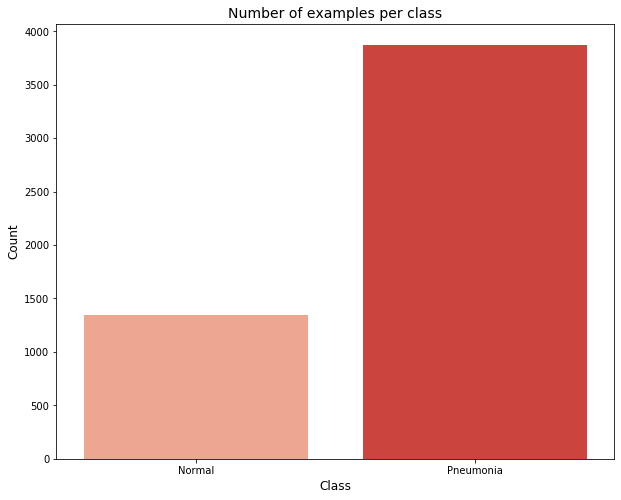

In [129]:
import matplotlib.pyplot as plt
import seaborn as sns


cases_count = train_df_exp['condition'].value_counts()


# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=cases_count.index, y= cases_count.values,palette='Reds')
plt.title('Number of examples per class', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()


## the training set is highly imbalanced and may cause incorrect results

## Data Preprocessing

In [135]:
import os
import pandas as pd
import random 


#### create a dataframe of image names from the folder and a column with the target variable condition (Pneumonia : Yes/No?)

#### as the data is imbalanced, the final test dataframe contains 
#### an equal number of examples of both the values of the condition


def create_df(locn_normal,locn_pneu,dtype):
    files_in_normal = sorted(os.listdir(locn_normal)) # list of images with no pneumonia
    files_in_pneu = sorted(os.listdir(locn_pneu))  # list of images with pneumonia
    files_total = files_in_normal + files_in_pneu
    df = pd.DataFrame(files_total)
    df.columns = ['file']
    df['condition'] = [0 if x in files_in_normal else 1 for x in df['file']] # create target variable
    
    # dealing with imbalanced classes
    df = df.groupby('condition').apply(lambda x: x.sample(n=len(files_in_normal))).reset_index(drop = True)
    
    # shuffling the dataset
    df = df.sample(frac=1).reset_index(drop=True)
    
    return(df)

In [138]:
#### Train, validation and test datasets
train_df = create_df(r'chest-xray-pneumonia\chest_xray\train\NORMAL',r'chest-xray-pneumonia\chest_xray\train\PNEUMONIA','train')
val_df = create_df(r'chest-xray-pneumonia\chest_xray\val\NORMAL',r'chest-xray-pneumonia\chest_xray\val\PNEUMONIA','val')
test_df = create_df(r'chest-xray-pneumonia\chest_xray\test\NORMAL',r'chest-xray-pneumonia\chest_xray\test\PNEUMONIA','test')

#### Number of examples
## train: 2682
## val: 16
## test: 468

In [15]:
### resize imaged


import PIL
from PIL import Image
def resize_image(BASE_DIR,imgtype,file):
    img = Image.open(BASE_DIR+file)
    img = img.resize((48,48), PIL.Image.ANTIALIAS)
    if imgtype=='test':
        img.save('resized_images\\'+'test\\'+file)
    elif imgtype=='train':
        img.save('resized_images\\'+'train\\'+file)
    else:
        img.save('resized_images\\'+'val\\'+file)

In [16]:
#### rezise training images

for i in train_df['file']:
    resize_image(r'train\\','train',i)

In [17]:
#### resize testing and validation images

for i in test_df['file']:
    resize_image(r'test\\','test',i)
for i in val_df['file']:
    resize_image(r'val\\','val',i)

In [149]:
#### function to display resized images

def display_first_as_img(df):
    plt.figure()
    plt.imshow(np.array(df).reshape([48,48]), 'gray')
    

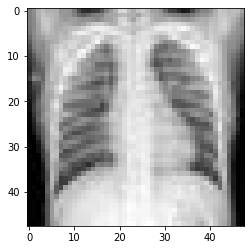

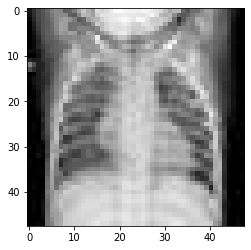

In [151]:
display_first_as_img(train_data[0])
display_first_as_img(train_data[-1])

## Create CNN model using Keras

In [132]:
import numpy
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.constraints import maxnorm
from keras.utils import np_utils

In [19]:
#### convert the resized images to pixels

train_data1 = list()
test_data1 = list()
val_data1= list()
import numpy as np
import imageio
def img_to_csv(locn,names,dataset):
    for i in names:
        img = (imageio.imread(locn+"\\"+i, as_gray=True))
        img = np.array(img)
        dataset.append( img)
    return dataset


In [20]:
#### convert the training, val and testing sets into pixel values

train_data = np.asarray(img_to_csv(r"resized_images\train",train_df['file'],train_data1),dtype=np.float32)
test_data =  np.asarray(img_to_csv(r"resized_images\test",test_df['file'],test_data1),dtype=np.float32)
val_data =  np.asarray(img_to_csv(r"resized_images\val",val_df['file'],val_data1),dtype=np.float32)


## reshape the data (no of examples, height, width, channels)
## as the images have been changed to greyscale, there is only 1 channel
train_data = train_data.reshape((2682, 48, 48,1))
test_data = test_data.reshape((468, 48, 48,1))
val_data = val_data.reshape((16, 48, 48,1))

In [21]:
#### change target variable to a categorical value

train_y = np_utils.to_categorical(train_df['condition'])
test_y = np_utils.to_categorical(test_df['condition'])
val_y = np_utils.to_categorical(val_df['condition'])

In [45]:
#### set seed
np.random.seed(4)

In [77]:
#### create CNN model

## 4 convolution layers with relu activation function and 1 softmax layer at the end
## A dropout layer after every convolution
## adam optimizer and 15 epochs

model = Sequential()
model.add(Conv2D(48, (3, 3), input_shape=(48,48,1), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(48, (3, 3), input_shape=(48, 48), activation='relu', padding='same'))
model.add(Dropout(0.2,seed=4))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(96, (3, 3), input_shape=(48, 48), activation='relu', padding='same'))
model.add(Dropout(0.2,seed=4))
model.add(Flatten())
model.add(Dropout(0.2,seed=4))
model.add(Dense(2))
model.add(Activation('softmax'))

epochs = 15
optimizer = 'adam'
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [78]:
### training the model and validating it 

model.fit(train_data, train_y, validation_data=(val_data, val_y), epochs=epochs, batch_size=96)

Train on 2682 samples, validate on 16 samples
Epoch 1/15
2682/2682 [==============================] - 89s 33ms/step - loss: 2.9447 - accuracy: 0.5015 - val_loss: 0.6952 - val_accuracy: 0.5000
Epoch 2/15
2682/2682 [==============================] - 87s 32ms/step - loss: 0.5825 - accuracy: 0.6887 - val_loss: 0.6942 - val_accuracy: 0.6250
Epoch 3/15
2682/2682 [==============================] - 87s 32ms/step - loss: 0.4315 - accuracy: 0.7990 - val_loss: 0.6111 - val_accuracy: 0.6250
Epoch 4/15
2682/2682 [==============================] - 87s 32ms/step - loss: 0.3178 - accuracy: 0.8680 - val_loss: 0.5251 - val_accuracy: 0.8125
Epoch 5/15
2682/2682 [==============================] - 87s 32ms/step - loss: 0.2704 - accuracy: 0.8919 - val_loss: 0.5147 - val_accuracy: 0.6250
Epoch 6/15
2682/2682 [==============================] - 87s 32ms/step - loss: 0.2181 - accuracy: 0.9176 - val_loss: 0.4668 - val_accuracy: 0.8750
Epoch 7/15
2682/2682 [==============================] - 87s 33ms/step - loss: 

In [79]:
## accuracy of the model on the testing data

scores = model.evaluate(test_data, test_y, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.34%


([<matplotlib.axis.YTick at 0x1d31df66908>,
 <a list of 2 Text yticklabel objects>)

<Figure size 432x288 with 0 Axes>

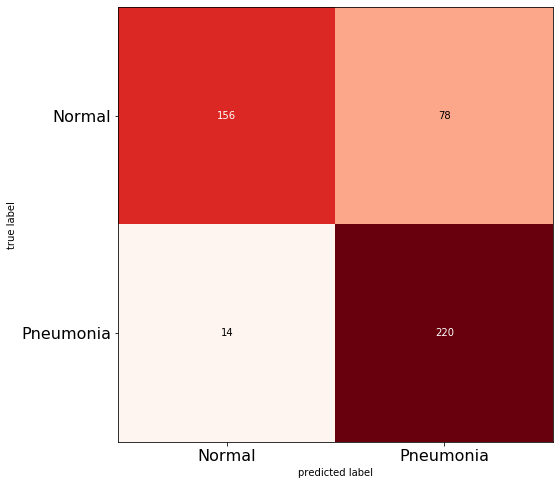

In [131]:
## plot the confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

preds = model.predict(test_data, batch_size=16)
preds = np.argmax(preds, axis=-1)

# Original labels
orig_test_labels = np.argmax(test_y, axis=-1)

cm  = confusion_matrix(orig_test_labels, preds)
plt.figure()
plot_confusion_matrix(cm,figsize=(12,8), hide_ticks=True, cmap=plt.cm.Reds)

plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)


In [81]:
## more metrics

tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.94
Precision of the model is 0.74
